In [17]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import random
from sklearn.preprocessing import StandardScaler

In [18]:
precip_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly2/'
temp_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly2/'
ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly2/'

In [19]:
precip_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/EA/'
temp_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/EA/'
ndvi_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/EA/'

In [20]:
def generate_dekads(start, end):
    '''
    Generates list of timestamps of dekads between two dates
    
    Parameters
    ----------
    start : pd.datetime object
        Start date of list
    end : pd.datetime object
        end date of list
    '''
    
    dtrange = pd.date_range(start, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    return dekads

In [21]:
start = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)

dekads = generate_dekads(start, end)

In [22]:
def stack_rasters(in_dir, keyword):
    
    '''
    This function creates a raster stack xarray DataArray given a specified variable keyword.
    Keywords = 'precip', 'ndvi','lst'
    
    '''
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]
    
    stacked = []
    
    for filename in tqdm(files): 
        if keyword in filename:
    
            file = xr.open_rasterio(in_dir+filename)
            stacked.append(file.sel(band=1))
            
    combined = xr.concat(stacked, dim = 'time')
  

    return combined.assign_coords(time=dekads)

In [23]:
#stack_out = stack_rasters(precip_dir, 'chirps')

#stack_out = stack_rasters(precip_ea, 'precip')
#stack_out = stack_rasters(ndvi_ea, 'ndvi')
stack_out_temp = stack_rasters(temp_ea, 'temp')

100%|██████████| 606/606 [00:09<00:00, 64.04it/s]


In [68]:
stack_out_precip = stack_rasters(precip_ea, 'precip')

100%|██████████| 606/606 [00:09<00:00, 63.19it/s]


In [37]:
stack_out_ndvi = stack_rasters(ndvi_ea, 'ndvi')

100%|██████████| 606/606 [00:16<00:00, 35.75it/s]


In [123]:
#stack_out.resample(time='M').mean('time')

In [122]:
#stack_out-stack_out.resample(time='M').mean('time')

In [121]:
#stack_out.resample(time = 'M')

In [126]:
#ds_anom = stack_out - stack_out.mean("time")

In [127]:
#ds_anom.min()

In [18]:
stack_out_precip.max()

<xarray.DataArray ()>
array(1043.2545, dtype=float32)
Coordinates:
    band     int64 1

In [20]:
stack_out_precip.groupby('time.month')

In [15]:
ds_anom_precip = stack_out_precip.groupby('time.month') - stack_out_precip.groupby("time.month").mean("time")

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
ds_ndvi = (stack_out_ndvi-100)/100
ds_anom_ndvi = ds_ndvi.groupby('time.month') - ds_ndvi.groupby('time.month').mean('time')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [38]:
time_month_group = list(stack_out_temp.groupby('time.month'))

In [ ]:
time_month_group[0]

In [48]:
temp_climatology = stack_out_temp.groupby('time.month').mean('time')

In [ ]:
temp_climatology

In [80]:
temp_climatology.max()

<xarray.DataArray ()>
array(61.597855, dtype=float32)
Coordinates:
    band     int64 1

In [30]:
ds_anom_temp = stack_out_temp.groupby('time.month') - stack_out_temp.groupby("time.month").mean("time")

In [82]:
ds_anom_temp.min()

<xarray.DataArray ()>
array(-36.939087, dtype=float32)
Coordinates:
    band     int64 1

In [35]:
ds_anom_mean = (stack_out_temp - stack_out_temp.mean('time'))/stack_out_temp.std('time')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [43]:
ds_ndvi = (stack_out_ndvi - 100)/100

In [44]:
ds_anom_ndvi_mean2 = (ds_ndvi - ds_ndvi.mean('time'))/ds_ndvi.std('time')

In [38]:
ds_anom_ndvi_mean = (stack_out_ndvi - stack_out_ndvi.mean('time'))/stack_out_ndvi.std('time')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [49]:
ds_ndvi.mean('time')

<xarray.DataArray (y: 674, x: 583)>
array([[0.09117828, 0.09251844, 0.09320319, ..., 0.09121244, 0.08994331,
        0.08749428],
       [0.09023433, 0.09069153, 0.09236404, ..., 0.09116904, 0.08921036,
        0.08731683],
       [0.08836424, 0.08917318, 0.09146635, ..., 0.09074443, 0.08856204,
        0.08733147],
       ...,
       [0.5399493 , 0.5790738 , 0.63454306, ...,        nan,        nan,
               nan],
       [0.53436005, 0.55812305, 0.59067565, ...,        nan,        nan,
               nan],
       [0.5226095 , 0.54972607, 0.55349195, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    band     int64 1
  * x        (x) float64 22.02 22.07 22.12 22.18 ... 50.98 51.03 51.08 51.12
  * y        (y) float64 21.98 21.93 21.88 21.82 ... -11.52 -11.58 -11.62 -11.68

In [53]:
ds_ndvi[0,0][0].values

array(0.09565865, dtype=float32)

In [46]:
ds_anom_ndvi_mean3 = (ds_ndvi - ds_ndvi.mean('time'))

In [70]:
ds_anom_precip_mean3 = (stack_out_precip - stack_out_precip.mean('time'))

In [25]:
ds_anom_temp_mean3 = (stack_out_temp - stack_out_temp.mean('time'))

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
#use this just for NDVI

#ds_ndvi = (stack_out-100)/100
#ds_anom = ds_ndvi.groupby('time.month') - ds_ndvi.groupby('time.month').mean('time')

#all other variables
#ds_anom = stack_out.groupby('time.month') - stack_out.groupby("time.month").mean("time")

In [27]:
def dataarray2tiff(dataarray, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D xarray DataArray into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile
        
    for i in np.arange(0,len(os.listdir(in_dir))):
        data = np.array(dataarray[i])
        
       
        with rasterio.open(out_dir + out_name + str(np.array(dataarray[i].time))[:10] + '.tif', 'w', **profile) as dst:
            
            data = data.astype(np.float32)
            dst.write(data, indexes = 1)

In [35]:
dataarray2tiff(ds_anom, precip_ea, precip_anom_dir, 'anom_ea_precip_')

In [ ]:
dataarray2tiff(ds_anom, ndvi_ea, ndvi_anom_dir, 'anom_ea_ndvi_')

In [ ]:
dataarray2tiff(ds_anom, temp_ea, temp_anom_dir, 'anom_ea_temp_')

In [ ]:
dataarray2tiff(ds_anom_ndvi, ndvi_ea, '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly3/', 'anom_ea_ndvi_')

In [ ]:
dataarray2tiff(ds_anom_ndvi_mean3, ndvi_ea, '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly3/', 'anom_ea_ndvi_')

In [72]:
dataarray2tiff(ds_anom_precip_mean3, precip_ea, '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly3/', 'anom_ea_precip_')

In [ ]:
dataarray2tiff(ds_anom_temp_mean3, temp_ea, '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly3/', 'anom_ea_temp_')

In [4]:
def pixelwise_ts_table(in_dir, keyword):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['precip', 'temp', 'ndvi']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains(keyword)
    files = files[tifs]
    #n_samples = len(files)
    
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        
            open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
            array = open_file.values
            #
            pixel_list = array.ravel().tolist()
            
            pixelwise_TS.append(pixel_list)

        
    return pd.DataFrame(pixelwise_TS)

    

In [8]:
ndvi_orig_table = pixelwise_ts_table(ndvi_ea, 'ndvi')

100%|██████████| 606/606 [00:10<00:00, 59.54it/s]


In [21]:
#ndvi_table2 = pixelwise_ts_table('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly3/', 'ndvi')

In [9]:
ndvi_table_anom1 = pixelwise_ts_table('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/', 'ndvi')

100%|██████████| 606/606 [00:09<00:00, 65.45it/s]


In [10]:
ndvi_table_anom2 = pixelwise_ts_table('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly2/', 'ndvi')

100%|██████████| 606/606 [00:17<00:00, 35.46it/s]


In [11]:
ndvi_table_anom3 = pixelwise_ts_table('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly3/', 'ndvi')

100%|██████████| 606/606 [00:18<00:00, 33.38it/s]


In [5]:
precip_orig_table = pixelwise_ts_table(precip_ea, 'precip')

100%|██████████| 606/606 [00:09<00:00, 64.44it/s]


In [12]:
precip_table_anom1 = pixelwise_ts_table('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/', 'precip')

100%|██████████| 606/606 [00:18<00:00, 32.37it/s]


In [28]:
precip_table_anom2 = pixelwise_ts_table('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly2/', 'precip')

100%|██████████| 606/606 [00:22<00:00, 27.23it/s]


In [9]:
precip_table_anom3 = pixelwise_ts_table('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly3/', 'precip')

100%|██████████| 606/606 [00:13<00:00, 44.03it/s]


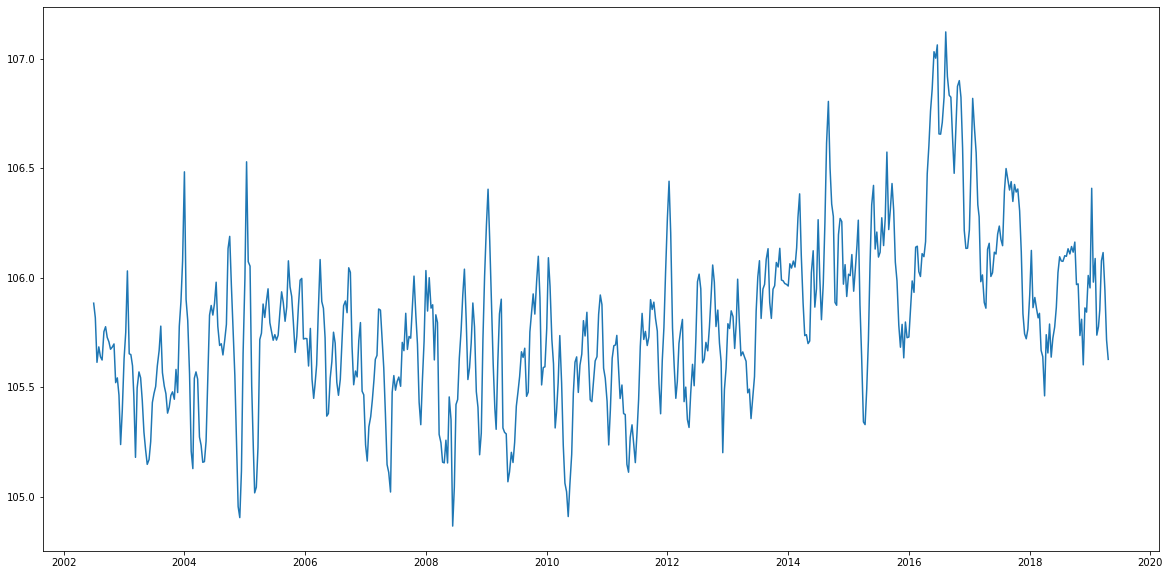

In [22]:
fig = plt.figure(figsize =(20,10))
plt.plot(dekads, ndvi_orig_table[1000])

In [24]:
ndvi_orig_table[0]

0      109.565865
1      109.516815
2      109.369995
3      109.540482
4      109.512871
          ...    
601    109.202431
602    109.330482
603    109.252777
604    109.242531
605    109.301773
Name: 0, Length: 606, dtype: float64

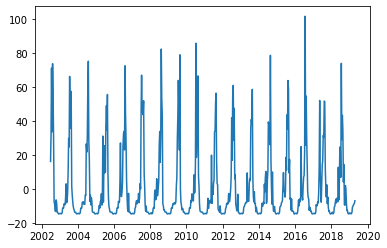

In [18]:
plt.plot(dekads, precip_table_anom2[69701])

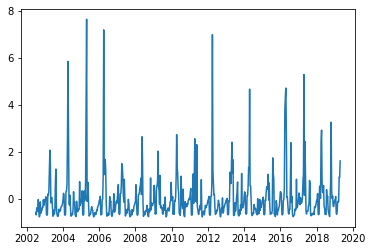

In [13]:
plt.plot(dekads, precip_table_anom1[28965])

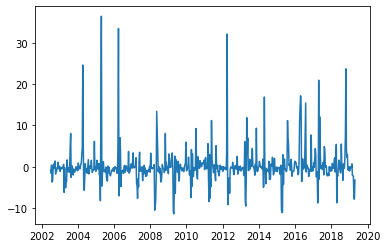

In [11]:
plt.plot(dekads, precip_table_anom2[28965])

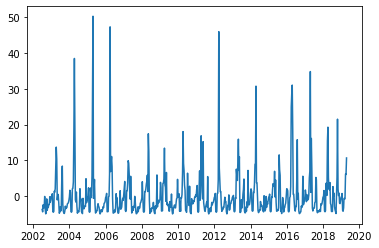

In [14]:
plt.plot(dekads, precip_table_anom3[28965])

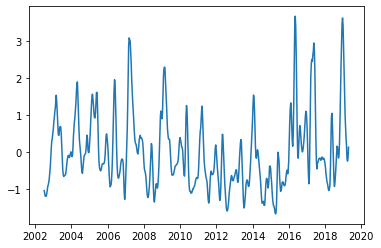

In [66]:
plt.plot(dekads, ndvi_table_anom1[28965])

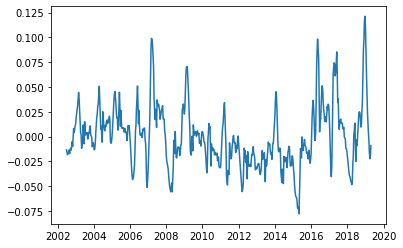

In [67]:
plt.plot(dekads, ndvi_table_anom2[28965])

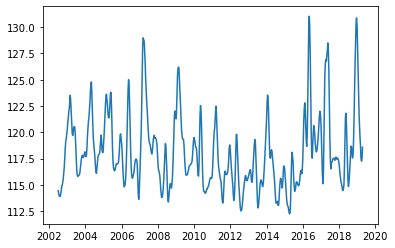

In [62]:
plt.plot(dekads, ndvi_orig_table[28965])

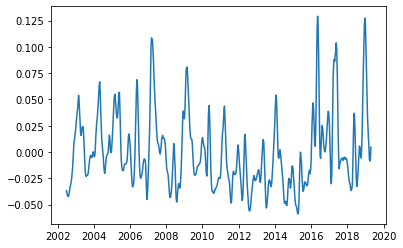

In [59]:
plt.plot(dekads, ndvi_table2[28965])

In [26]:
plt.plot(dekads, ndvi_table2[69701])

NameError: name 'ndvi_table2' is not defined

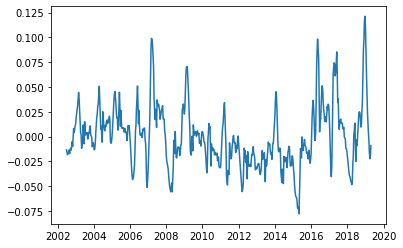

In [16]:
plt.plot(dekads, ndvi_table[28965])

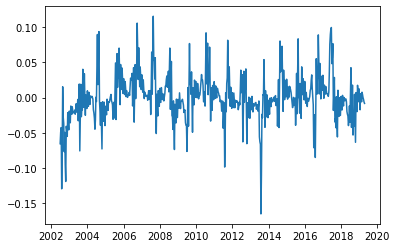

In [17]:
plt.plot(dekads, ndvi_table[69701])

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


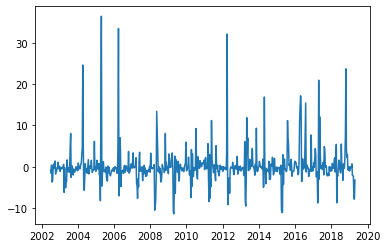

In [9]:
plt.plot(dekads, precip_table[28965])

In [10]:
temp_table = pixelwise_ts_table(temp_anom_dir, 'temp')

100%|██████████| 606/606 [00:09<00:00, 63.03it/s]


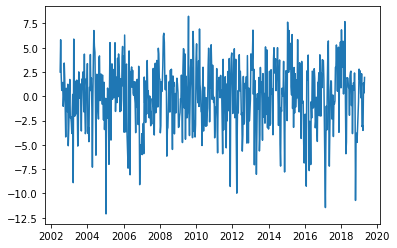

In [12]:
plt.plot(dekads, temp_table[28965])

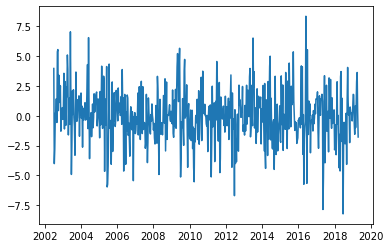

In [13]:
plt.plot(dekads, temp_table[69701])

In [33]:
precip_table_anom2[1000]

0      -0.023898
1      -0.093976
2       0.106496
3      -0.183794
4      -0.046803
         ...    
601    -3.584621
602     6.822517
603    -3.510975
604   -11.328547
605   -11.062061
Name: 1000, Length: 606, dtype: float64

In [40]:
54+36

90

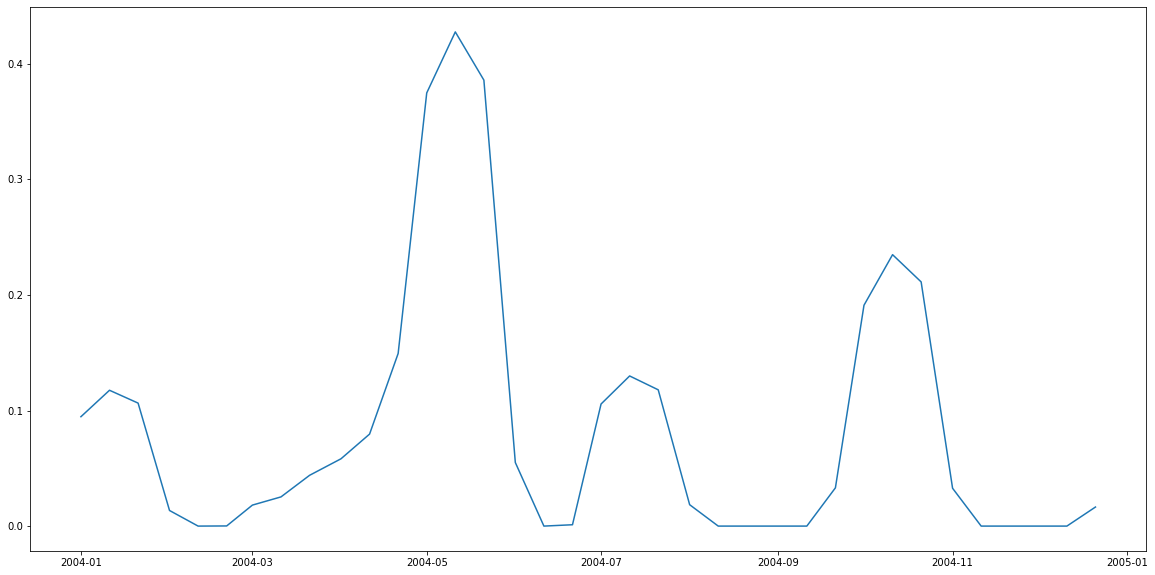

In [14]:
fig = plt.figure(figsize=(20,10))
plt.plot(dekads[54:90], precip_orig_table[5][54:90])

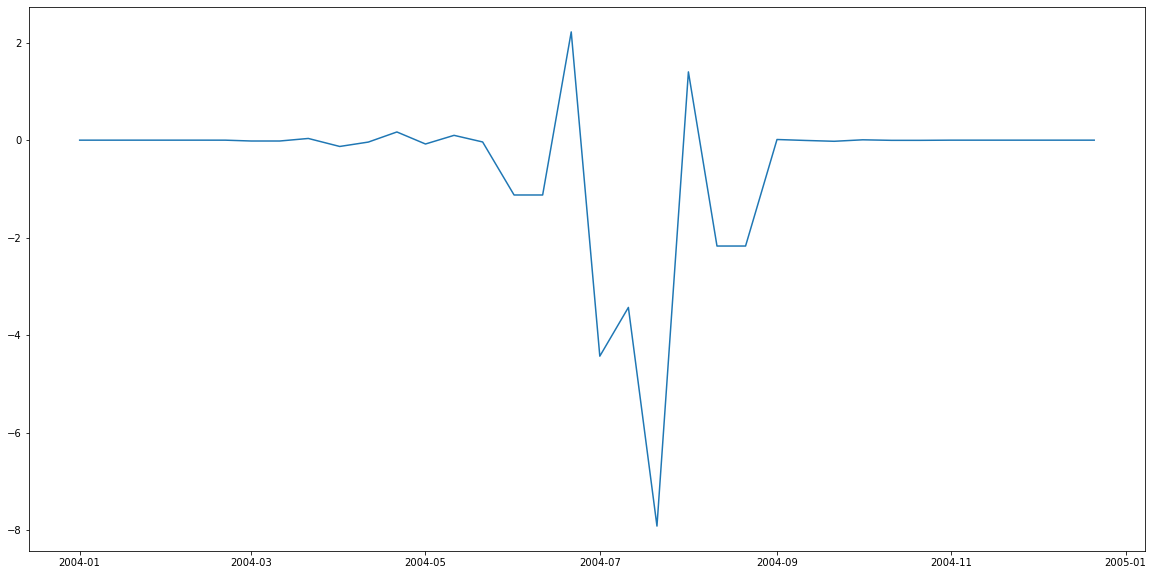

In [43]:
fig = plt.figure(figsize=(20,10))
plt.plot(dekads[54:90], precip_table_anom2[45000][54:90])

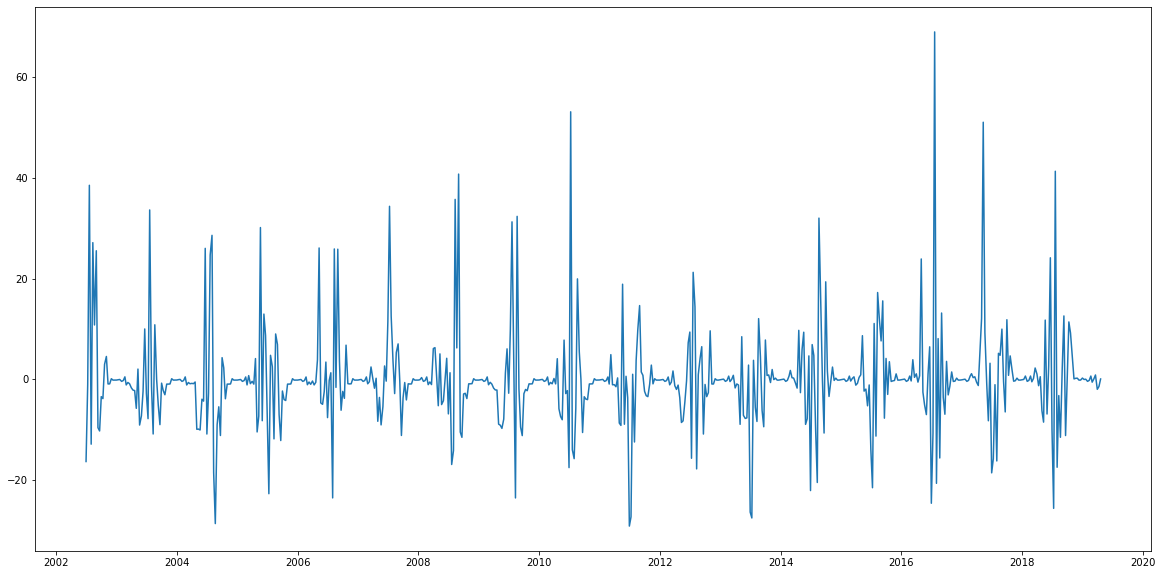

In [30]:
fig = plt.figure(figsize=(20,10))
plt.plot(dekads, precip_table_anom2[69701])

In [27]:
plt.plot(dekads, precip_table[69701])

NameError: name 'precip_table' is not defined

In [95]:
temp_orig_table = pixelwise_ts_table(temp_ea, 'temp')

100%|██████████| 606/606 [00:08<00:00, 71.91it/s]


In [91]:
temp_table[0].min()

-7.293241500854492

In [93]:
temp_table[0].max()

10.011798858642578

In [94]:
temp_table[0].mean()

-1.7940407932394802e-07